In [1]:
import glob
import os
import re
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from Bio import SeqIO
from Bio.SeqUtils import gc_fraction as GC

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

In [3]:
GENBANK_DIR = "../../data/ncbi_data/gen_bank/train/Lysogneic"
OUTPUT_DIR = "phage_analysis_results"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [4]:
def analyze_genbank_file(file_path):
    """Phân tích một file GenBank và trả về thông tin cần thiết"""
    try:
        record = SeqIO.read(file_path, "genbank")

        basic_info = {
            "file_name": os.path.basename(file_path),
            "accession": record.id,
            "name": record.name,
            "description": record.description,
            "length": len(record.seq),
            "gc_content": GC(record.seq),
            "num_features": len(record.features)
        }

        genes_data = []
        feature_types = Counter()

        for feature in record.features:
            feature_types[feature.type] += 1

            if feature.type == "CDS":
                locus_tag = feature.qualifiers.get("locus_tag", ["Unknown"])[0]
                gene_name = feature.qualifiers.get("gene", ["Unknown"])[0]
                product = feature.qualifiers.get("product", ["Unknown"])[0]
                protein_id = feature.qualifiers.get("protein_id", ["Unknown"])[0]
                translation = feature.qualifiers.get("translation", [""])[0]
                note = feature.qualifiers.get("note", [""])[0]
                function = feature.qualifiers.get("function", [""])[0]

                gene_info = {
                    "locus_tag": locus_tag,
                    "gene_name": gene_name,
                    "product": product,
                    "protein_id": protein_id,
                    "start": int(feature.location.start),
                    "end": int(feature.location.end),
                    "strand": "+" if feature.location.strand == 1 else "-",
                    "length": len(feature.location),
                    "protein_length": len(translation) if translation else 0,
                    "note": note,
                    "function": function,
                    "file_path": file_path
                }
                genes_data.append(gene_info)

        result = {
            "basic_info": basic_info,
            "genes_df": pd.DataFrame(genes_data) if genes_data else pd.DataFrame(),
            "list_distinct_gene_names": list(set(gene["gene_name"] for gene in genes_data)),
            "list_distinct_products": list(set(gene["product"] for gene in genes_data)),
            "num_genes": len(genes_data),
            "feature_types": feature_types
        }

        return result

    except Exception as e:
        print(f"Lỗi khi xử lý file {file_path}: {str(e)}")
        return None

# analyze_genbank_file(os.path.join(GENBANK_DIR, "train_NC_000902_Lysogneic_Group1.gb"))

In [5]:
def process_genbank_files():
    gb_files = []
    for group in os.listdir(GENBANK_DIR):
        gb_files += glob.glob(os.path.join(GENBANK_DIR, group, "*.gb"))

    if not gb_files:
        print(f"Không tìm thấy file GenBank trong thư mục {GENBANK_DIR}")
        return None

    print(f"Tìm thấy {len(gb_files)} file GenBank. Đang xử lý...")

    all_results = []
    for i, file_path in enumerate(gb_files):
        print(f"Đang xử lý file {i + 1}/{len(gb_files)}: {os.path.basename(file_path)}")
        result = analyze_genbank_file(file_path)
        if result:
            all_results.append(result)

    print(f"Đã xử lý xong {len(all_results)}/{len(gb_files)} file GenBank.")
    return all_results

In [6]:
def analyze_and_visualize(all_results):
    if not all_results:
        print("Không có dữ liệu để phân tích.")
        return

    basic_info_list = [r["basic_info"] for r in all_results]
    basic_df = pd.DataFrame(basic_info_list)

    lifestyle_data = []
    for r in all_results:
        lifestyle_info = {
            "accession": r["basic_info"]["accession"],
            "name": r["basic_info"]["name"],
            "length": r["basic_info"]["length"],
            "gc_content": r["basic_info"]["gc_content"],
            "num_features": r["basic_info"]["num_features"]
        }
        lifestyle_data.append(lifestyle_info)

    lifestyle_df = pd.DataFrame(lifestyle_data)

    basic_df.to_csv(os.path.join(OUTPUT_DIR, "phage_basic_info.csv"), index=False)
    lifestyle_df.to_csv(os.path.join(OUTPUT_DIR, "phage_lifestyle_prediction.csv"), index=False)

    all_genes_data = []
    for r in all_results:
        if not r["genes_df"].empty:
            # Thêm accession để biết gene thuộc phage nào
            genes_df = r["genes_df"].copy()
            genes_df["accession"] = r["basic_info"]["accession"]
            genes_df["phage_name"] = r["basic_info"]["name"]
            all_genes_data.append(genes_df)

    if all_genes_data:
        all_genes_df = pd.concat(all_genes_data, ignore_index=True)
        all_genes_df.to_csv(os.path.join(OUTPUT_DIR, "all_phage_genes.csv"), index=False)
    else:
        all_genes_df = pd.DataFrame()

    gene_names = set([name for r in all_results for name in r["list_distinct_gene_names"]])
    print(f"Số lượng gene names duy nhất: {len(set(gene_names))}")
    print(f"\n\n{gene_names}\n\n")
    gene_counts = Counter(gene_names)
    df_genes = pd.DataFrame({
        'gene': list(gene_counts.keys()),
        'count': list(gene_counts.values())
    })
    df_genes = df_genes.sort_values('count', ascending=False)
    top_genes = df_genes.head(20)
    plt.figure(figsize=(12, 8))
    plt.bar(top_genes['gene'], top_genes['count'])
    plt.xticks(rotation=90)
    plt.xlabel('Tên gen')
    plt.ylabel('Số lần xuất hiện')
    plt.title('Top 20 gen xuất hiện nhiều nhất')
    plt.tight_layout()
    plt.show()

    products = set([product for r in all_results for product in r["list_distinct_products"]])
    print(f"Số lượng products duy nhất: {len(set(products))}")
    print(f"\n\n{products}\n\n")
    product_counts = Counter(products)
    df_products = pd.DataFrame({
        'product': list(product_counts.keys()),
        'count': list(product_counts.values())
    })
    df_products = df_products.sort_values('count', ascending=False)
    top_products = df_products.head(20)
    plt.figure(figsize=(12, 8))
    plt.bar(top_products['product'], top_products['count'])
    plt.xticks(rotation=90)
    plt.xlabel('Tên sản phẩm')
    plt.ylabel('Số lần xuất hiện')
    plt.title('Top 20 sản phẩm gen xuất hiện nhiều nhất')
    plt.tight_layout()
    plt.show()

    print("Tạo đồ thị và báo cáo...")

    plt.figure(figsize=(10, 6))
    sns.histplot(basic_df["length"], kde=True)
    plt.title("Phân bố kích thước genome của thực khuẩn")
    plt.xlabel("Kích thước (bp)")
    plt.ylabel("Số lượng")
    plt.savefig(os.path.join(OUTPUT_DIR, "genome_size_distribution.png"), dpi=300, bbox_inches="tight")

    plt.figure(figsize=(10, 6))
    sns.histplot(basic_df["gc_content"], kde=True)
    plt.title("Phân bố GC content của thực khuẩn")
    plt.xlabel("GC Content (%)")
    plt.ylabel("Số lượng")
    plt.savefig(os.path.join(OUTPUT_DIR, "gc_content_distribution.png"), dpi=300, bbox_inches="tight")

    print(f"Đã lưu các kết quả phân tích vào thư mục: {OUTPUT_DIR}")
    return {
        "basic_df": basic_df,
        "lifestyle_df": lifestyle_df,
        "all_genes_df": all_genes_df
    }

Tìm thấy 579 file GenBank. Đang xử lý...
Đang xử lý file 1/579: train_NC_000902_Lysogneic_Group1.gb
Đang xử lý file 2/579: train_NC_000935_Lysogneic_Group1.gb
Đang xử lý file 3/579: train_NC_001396_Lysogneic_Group1.gb
Đang xử lý file 4/579: train_NC_001416_Lysogneic_Group1.gb
Đang xử lý file 5/579: train_NC_001418_Lysogneic_Group1.gb
Đang xử lý file 6/579: train_NC_001697_Lysogneic_Group1.gb
Đang xử lý file 7/579: train_NC_001895_Lysogneic_Group1.gb
Đang xử lý file 8/579: train_NC_002666_Lysogneic_Group1.gb
Đang xử lý file 9/579: train_NC_002669_Lysogneic_Group1.gb
Đang xử lý file 10/579: train_NC_002671_Lysogneic_Group1.gb
Đang xử lý file 11/579: train_NC_002703_Lysogneic_Group1.gb
Đang xử lý file 12/579: train_NC_002730_Lysogneic_Group1.gb
Đang xử lý file 13/579: train_NC_003085_Lysogneic_Group1.gb
Đang xử lý file 14/579: train_NC_003157_Lysogneic_Group1.gb
Đang xử lý file 15/579: train_NC_003313_Lysogneic_Group1.gb
Đang xử lý file 16/579: train_NC_003315_Lysogneic_Group1.gb
Đang xử 

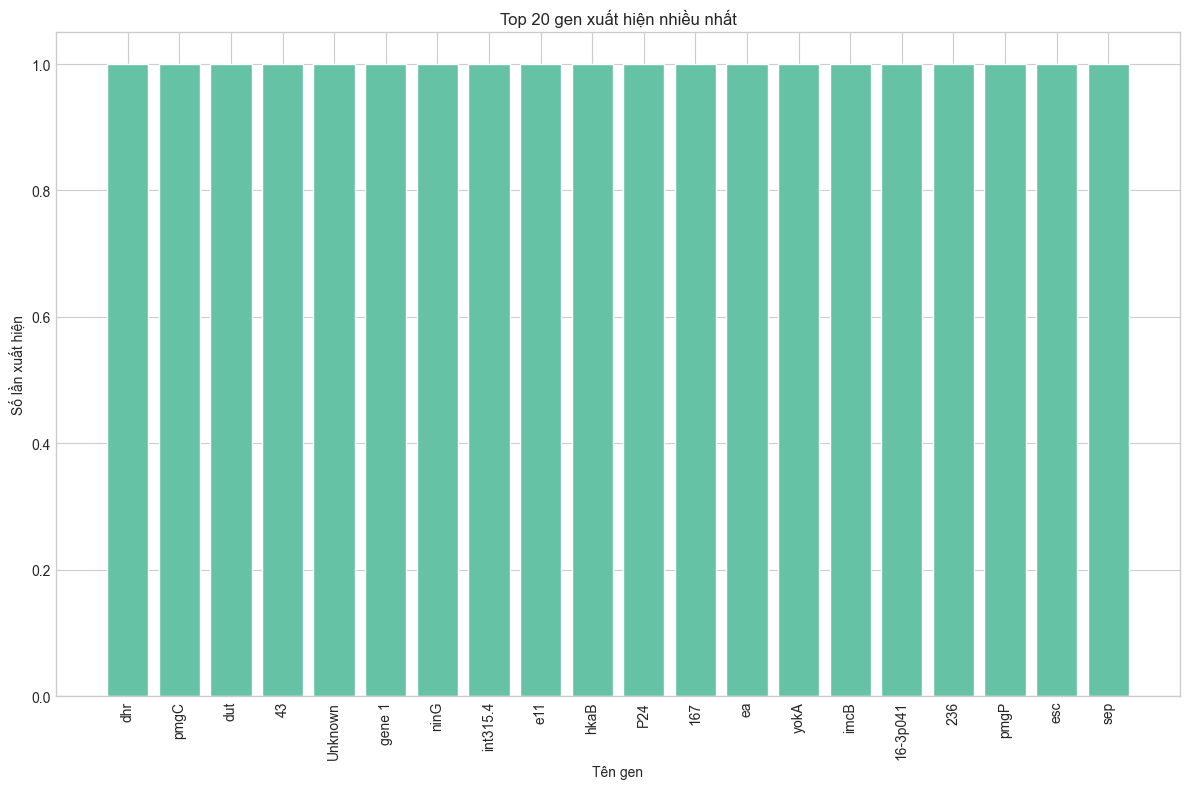

Số lượng products duy nhất: 2690


{'RNA polymerase', 'hol-like chemotaxis', 'gp01 protein', 'DNA ejection', 'transcriptional regulator', 'regulatory protein GemA', 'protein gop', '77ORF037', 'putative phage assembly protein', 'regulatory protein Q', 'putative phage replication protein', 'DUF739 family protein', 'PacA', 'primosomal protein', 'ORF143', 'p013', 'Cro', 'putative DnaD', 'gp18, conserved hypothetical protein', 'T3SS secreted effector Ibe', 'Rha protein', 'DUF4406 domain-containing protein', 'ProQ/FinO family protein', 'botulinum neurotoxin hemagglutinin HA70 subunit', 'collagen triple helix repeat', 'PmgF', 'helix-turn-helix transcriptional regulator', 'gene 43 protein', 'putative Cro-like repressor', 'spore protease', 'EaF protein', 'Orf21', 'ORF007', 'Upf86.8', 'cell division protein FtsZ', 'zonula occludens toxin ZOT', 'gene 38 protein', 'phage protein', 'inhibitor of alpha-polymerase', 'Cell surface protein N-acetylmuramoyl-L-alanine amidase LytC precursor', 'ORF6', 'co

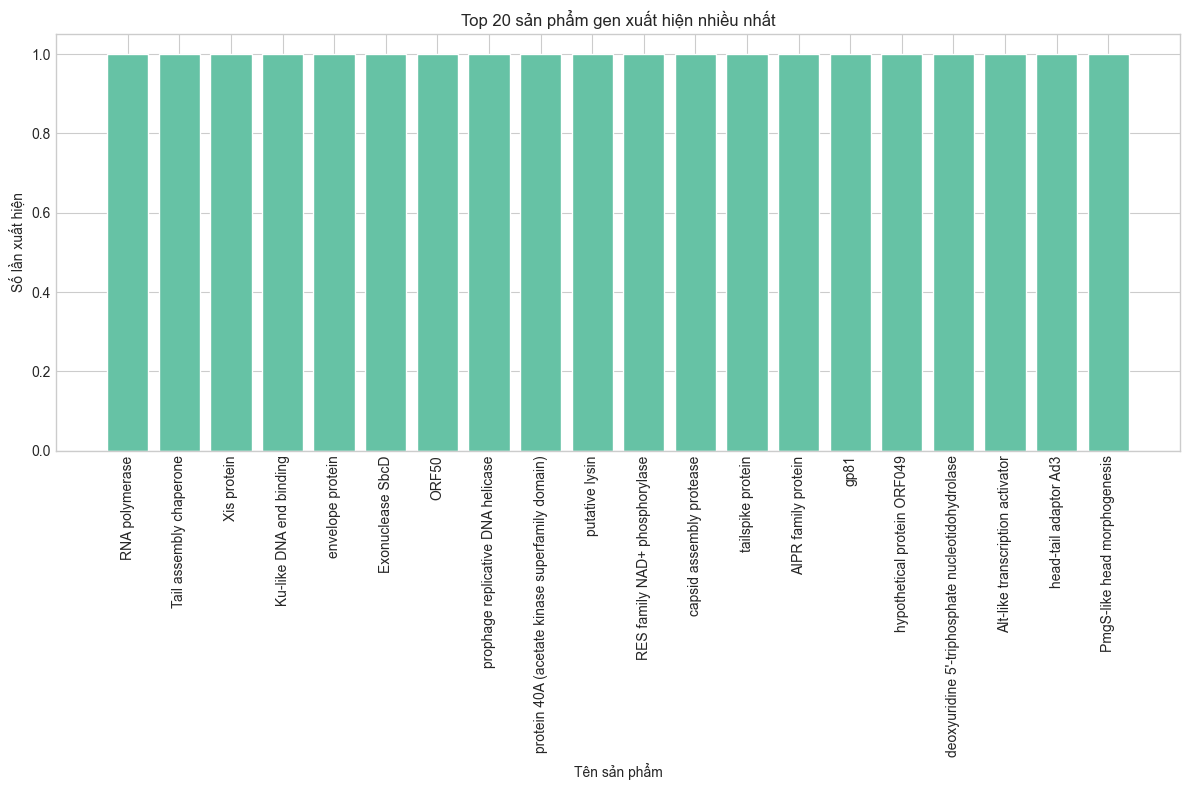

Tạo đồ thị và báo cáo...
Đã lưu các kết quả phân tích vào thư mục: phage_analysis_results
Phân tích hoàn tất!


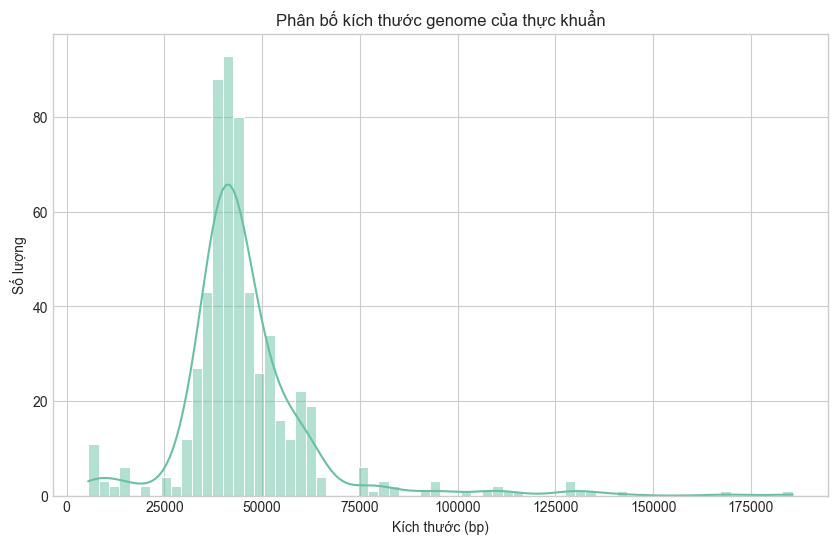

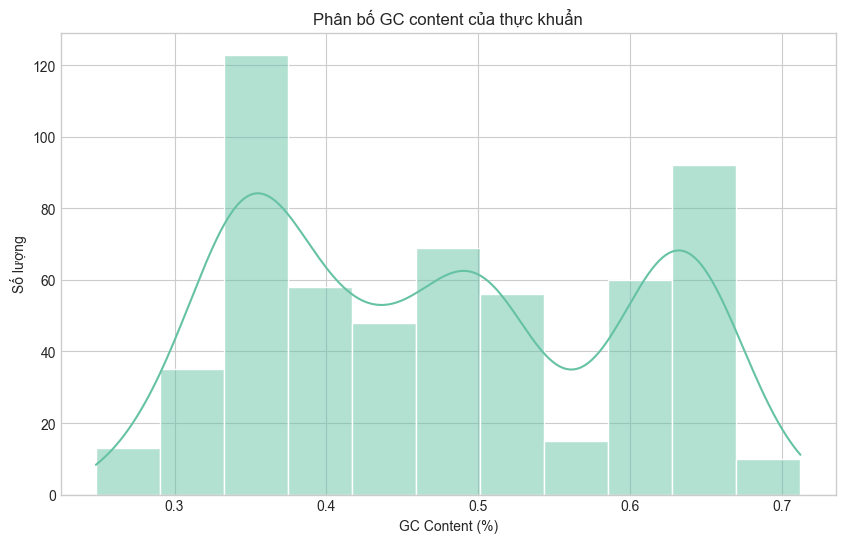

In [7]:
all_results = process_genbank_files()

if all_results:
    data_frames = analyze_and_visualize(all_results)
    print("Phân tích hoàn tất!")

    # return data_frames
else:
    print("Không có kết quả để phân tích.")
    # return None

In [8]:
all_gen_df = data_frames.get('all_genes_df')

In [9]:
def check_pattern(value):
    bounded_patterns = [r'\b' + re.escape(pattern) + r'\b' for pattern in search_pattern]
    pattern = re.compile('|'.join(bounded_patterns), re.IGNORECASE)
    return bool(pattern.search(str(value)))

In [10]:
search_pattern = [
    "integrase",
    "int gene",
    "int protein",
    "site-specific integrase",
    "phage integrase",
    "tyrosine integrase",
    "serine integrase",
    "int",
    "intA",
    "intB"
]

int_df = all_gen_df[
    ((all_gen_df['product'].apply(check_pattern)) |
     (all_gen_df['gene_name'] == 'int'))
    # ~(all_gen_df['product'].str.contains('|'.join(exception), case=False))
]

In [11]:
search_pattern = [
    "excisionase",
    "xis gene",
    "xis protein",
    "recombination directionality factor",
    "rdf",
    "excision protein",
    "xis"
]

xis_df = all_gen_df[
    (all_gen_df['product'].apply(check_pattern)) |
    # (all_gen_df['note'].apply(check_integrase)) |
    (all_gen_df['gene_name'] == 'xis')
    ]

In [12]:
search_pattern = [
    "recombinase",
    "site-specific recombinase",
    "tyrosine recombinase",
    "serine recombinase",
    "dna recombinase",
    "rec",
    "recA"
]

rec_df = all_gen_df[
    (all_gen_df['product'].apply(check_pattern)) |
    # (all_gen_df['note'].apply(check_integrase)) |
    (all_gen_df['gene_name'].isin(['rec', 'recA', 'recT', 'recD02']))
    ]

In [13]:
search_pattern = [
    "regulatory protein cro",
    "cro protein",
    "cro repressor",
    "cro",
    "transcriptional regulator cro"
]

cro_df = all_gen_df[
    ((all_gen_df['product'].apply(check_pattern)) |
     (all_gen_df['gene_name'] == 'cro'))
]

In [14]:
search_pattern = [
    "antitermination protein Q",
    "protein Q",
    "Q protein",
    "late gene regulator Q",
    "transcription antiterminator Q"
]
q_df = all_gen_df[
    ((all_gen_df['product'].apply(check_pattern)) |
     (all_gen_df['gene_name'] == 'Q'))
]

In [15]:
search_pattern = ["cI repressor", "ci repressor", "cI protein", "lambda repressor", "immunity repressor",
                  "repressor protein cI", "cl protein", "cl repressor"]

ci_df = all_gen_df[
    ((all_gen_df['product'].apply(check_pattern)) |
     (all_gen_df['gene_name'] == 'cI'))
]

In [16]:
search_pattern = ["cII protein", "cii protein", "protein cII", "transcription activator cII", "cII", "cii"]
cii_df = all_gen_df[
    ((all_gen_df['product'].apply(check_pattern)) |
     (all_gen_df['gene_name'] == 'cII'))
]

In [17]:
search_pattern = ["cIII protein", "ciii protein", "protein cIII", "cIII stabilization protein", "cIII", "ciii"]
ciii_df = all_gen_df[
    ((all_gen_df['product'].apply(check_pattern)) |
     (all_gen_df['gene_name'] == 'cIII'))
]

In [18]:
search_pattern = ["replication protein O", "O protein", "protein O", "replication initiation protein O",
                  "phage replication protein O", "dna replication protein O"]
o_df = all_gen_df[
    ((all_gen_df['product'].apply(check_pattern)) |
     (all_gen_df['gene_name'] == 'O'))
]

In [19]:
search_pattern = ["replication protein P", "P protein", "protein P", "replication initiation protein P",
                  "phage replication protein P", "dna replication protein P"]
p_df = all_gen_df[
    ((all_gen_df['product'].apply(check_pattern)) |
     (all_gen_df['gene_name'] == 'P'))
]

In [20]:
search_pattern = [
    "recombination protein Bet",
    "Bet protein",
    "bet protein",
    "bet",
    "Bet",
    "BET",
    "ssDNA annealing protein",
    "single-strand DNA binding protein",
    "DNA single-strand annealing protein",
    "RecT-like recombination protein",
    "Redβ",
    "Redβ recombinase",
    "Red beta protein",
    "Red beta recombination protein",
    "Redbeta",
    "Red-beta",
    "single strand annealing protein",
    "SSAP",
    "Bet",
    "bet"
]
bet_df = all_gen_df[
    ((all_gen_df['product'].apply(check_pattern)) |
     (all_gen_df['gene_name'] == 'bet'))
]

In [21]:
combined_df = pd.concat([int_df, xis_df, rec_df, cro_df, q_df, ci_df, cii_df, ciii_df, o_df, p_df, bet_df], axis=0)
combined_df.head()

,locus_tag,gene_name,product,protein_id,start,end,strand,length,protein_length,note,function,file_path,accession,phage_name
0,VT2-Sap01,int,integrase,NP_050500.1,28,1363,-,1335,444,,recombination,../../data/ncbi_data/gen_bank/train/Lysogneic\...,NC_000902.1,NC_000902
120,APSE-1_38,Unknown,integrase,NP_050999.1,23492,24665,-,1173,390,putative integrase,,../../data/ncbi_data/gen_bank/train/Lysogneic\...,NC_000935.1,NC_000935
175,lambdap33,int,integrase,NP_040609.1,27811,28882,-,1071,356,,,../../data/ncbi_data/gen_bank/train/Lysogneic\...,NC_001416.1,NC_001416
228,HP1p01,int,integrase,NP_043466.1,697,1711,-,1014,337,,,../../data/ncbi_data/gen_bank/train/Lysogneic\...,NC_001697.1,NC_001697
299,P2p31,int,integrase,NP_046786.1,24461,25475,-,1014,337,Int; binds dsDNA; cleaves and religates DNA th...,integrase,../../data/ncbi_data/gen_bank/train/Lysogneic\...,NC_001895.1,NC_001895


In [22]:
combined_df['locus_tag'].nunique()

1519

In [23]:
drop_dup_df = combined_df.drop_duplicates(keep='first')

In [24]:
def extract_sequence(row):
    try:
        record = SeqIO.read(row['file_path'], "genbank")
        start_pos = row['start']
        end_pos = row['end']
        seq_start = start_pos - 1
        sequence = record.seq[seq_start:end_pos]
        print(sequence.__len__())

        return str(sequence)
    except Exception as e:
        raise e

drop_dup_df['sequence'] = drop_dup_df.apply(lambda row: extract_sequence(row), axis=1)
drop_dup_df.head()

1336
1174
1072
1015
1015
1126
1186
1150
1126
1159
1726
1603
1099
1039
1015
1315
1051
547
1168
1288
1048
1144
1177
1207
1207
1093
1237
1165
1207
1051
1108
955
1108
1252
1024
1186
1216
1207
1177
946
1378
889
1267
1165
1276
1171
1048
1165
1036
1213
1333
1180
1114
1138
1027
892
1162
1252
1072
1180
1384
1387
190
1255
1012
1207
901
1072
1015
1171
1045
1021
994
982
1066
1201
1447
961
1117
868
1021
994
1354
1171
1312
982
970
922
1048
1039
1207
1168
175
997
1000
1204
1051
1027
1147
1198
1321
895
1120
883
1336
1108
1504
1282
1504
1510
997
1165
871
1321
1047
1051
1090
1144
1090
1204
982
1336
1648
1033
1048
1039
1051
1048
1051
1000
1048
1039
1144
1051
1204
1081
1189
1117
1129
1207
1288
847
1384
1174
1375
0
0
1165
1399
1174
1135
970
1102
544
1171
1312
1018
1123
1444
1075
1072
1162
1012
1162
1117
0
1255
169
673
1165
1153
901
1144
1039
1051
1156
1150
1447
1396
859
1207
1063
1165
1171
1111
1165
1183
2089
1027
1186
1225
1051
1195
1051
985
1159
1225
1573
1165
883
1573
1462
883
1120
1213
1126
973
1213
14

C:\Users\Admin\AppData\Local\Temp\ipykernel_16060\1879712084.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_dup_df['sequence'] = drop_dup_df.apply(lambda row: extract_sequence(row), axis=1)


,locus_tag,gene_name,product,protein_id,start,end,strand,length,protein_length,note,function,file_path,accession,phage_name,sequence
0,VT2-Sap01,int,integrase,NP_050500.1,28,1363,-,1335,444,,recombination,../../data/ncbi_data/gen_bank/train/Lysogneic\...,NC_000902.1,NC_000902,ATCATTTTGAAAAATATAATTTTATTTCATCCTCCTGGTCACTTTG...
120,APSE-1_38,Unknown,integrase,NP_050999.1,23492,24665,-,1173,390,putative integrase,,../../data/ncbi_data/gen_bank/train/Lysogneic\...,NC_000935.1,NC_000935,TTCAACTTTTTAATATTTTTAAGTGGGACAAATTTGGGACATGATT...
175,lambdap33,int,integrase,NP_040609.1,27811,28882,-,1071,356,,,../../data/ncbi_data/gen_bank/train/Lysogneic\...,NC_001416.1,NC_001416,ATTATTTGATTTCAATTTTGTCCCACTCCCTGCCTCTGTCATCACG...
228,HP1p01,int,integrase,NP_043466.1,697,1711,-,1014,337,,,../../data/ncbi_data/gen_bank/train/Lysogneic\...,NC_001697.1,NC_001697,TTTACTGTGCAGGATTAGAAAGCGGGTTGAATTTGACCGCACTTTC...
299,P2p31,int,integrase,NP_046786.1,24461,25475,-,1014,337,Int; binds dsDNA; cleaves and religates DNA th...,integrase,../../data/ncbi_data/gen_bank/train/Lysogneic\...,NC_001895.1,NC_001895,GTTACTCTACTGTGGACACTGTGTGGACACTCTCGGCCTCAGTACC...


In [25]:
import random


def process_dna_sequence(row):
    seq = row['sequence'].upper()

    non_atgc = re.findall(r'[^ATGC]', seq)
    non_atgc_count = len(non_atgc)

    if non_atgc_count > 0 and non_atgc_count <= 10:
        print(seq)
        print()
        for char in set(non_atgc):
            replacement = random.choice(['A', 'T', 'G', 'C'])
            seq = seq.replace(char, replacement)

        return seq

    return seq


drop_dup_df['sequence_filled'] = drop_dup_df.apply(lambda row: process_dna_sequence(row), axis=1)
drop_dup_df.head()

AATGGCAACTAACGATGAATTAAAAAATMAATTAGCAAATAAACAAAATGGAGGGCAAGTAGCAAGCGCACAATCATTAGACTTAAAAGGTTTGCTAGAAGCACCGACAATGCGCAAGAAATTCGAAAAGGTACTAGATAAAAAAGCGCCTCAATTTTTAACTTCCCTTTTAAATCTTTAYAATGGCGACGACTATTTACAAAAAACWGACCCRATGACRGTTGTTACTTCYGCCATGGTAGCGGCAACACTAGATTTACCGATTGACAAAAATTTAGGTTATGCGTGGATTGTTCCTTACAAAGGCAGAGCACAGTTTCAGCTTGGTTATAAAGGATACATCCAGTTAGCACTACGCACAGGACAATATAAAAGTATTAATGTTATCGAAGTGCGAGAAGGCGAGTTACTAAAATGGAATCGACTTACTGAAGAAATCGAACTAGATTTAGACAACAATACAAGTGAAAAAGTCGTTGGTTACTGTGGTTATTTTCAGTTGATAAATGGCTTTGAAAAAACGGTCTATTGGACTCGCAAAGAAATTGAAGCACATAAAAAGAAATTTAGTAAATCAGACTTTGGATGGAAAAAAGATTACGATGCAATGGCTAAAAAGACTGTTCTTAGAAACATGTTAAGTAAATGGGGCATCTTATCCATCGACATGCAAACAGCGGTTACAGAGGACGAAGCAGAGCCTAGAGAACGAAAAGACGTTACAGACGATGAATCAATACCGGACATTATAGAGGCGCCTATAACGCCGTCTGACACGTTAGAAGCTGGCTCGGTAGTTCAAGGGTCAATGATCTAA



C:\Users\Admin\AppData\Local\Temp\ipykernel_25444\3697548530.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_dup_df['sequence_filled'] = drop_dup_df.apply(lambda row: process_dna_sequence(row), axis=1)


,locus_tag,gene_name,product,protein_id,start,end,strand,length,protein_length,note,function,file_path,accession,phage_name,sequence,sequence_filled
0,VT2-Sap01,int,integrase,NP_050500.1,28,1363,-,1335,444,,recombination,../../data/ncbi_data/gen_bank/train/Lysogneic\...,NC_000902.1,NC_000902,ATCATTTTGAAAAATATAATTTTATTTCATCCTCCTGGTCACTTTG...,ATCATTTTGAAAAATATAATTTTATTTCATCCTCCTGGTCACTTTG...
120,APSE-1_38,Unknown,integrase,NP_050999.1,23492,24665,-,1173,390,putative integrase,,../../data/ncbi_data/gen_bank/train/Lysogneic\...,NC_000935.1,NC_000935,TTCAACTTTTTAATATTTTTAAGTGGGACAAATTTGGGACATGATT...,TTCAACTTTTTAATATTTTTAAGTGGGACAAATTTGGGACATGATT...
175,lambdap33,int,integrase,NP_040609.1,27811,28882,-,1071,356,,,../../data/ncbi_data/gen_bank/train/Lysogneic\...,NC_001416.1,NC_001416,ATTATTTGATTTCAATTTTGTCCCACTCCCTGCCTCTGTCATCACG...,ATTATTTGATTTCAATTTTGTCCCACTCCCTGCCTCTGTCATCACG...
228,HP1p01,int,integrase,NP_043466.1,697,1711,-,1014,337,,,../../data/ncbi_data/gen_bank/train/Lysogneic\...,NC_001697.1,NC_001697,TTTACTGTGCAGGATTAGAAAGCGGGTTGAATTTGACCGCACTTTC...,TTTACTGTGCAGGATTAGAAAGCGGGTTGAATTTGACCGCACTTTC...
299,P2p31,int,integrase,NP_046786.1,24461,25475,-,1014,337,Int; binds dsDNA; cleaves and religates DNA th...,integrase,../../data/ncbi_data/gen_bank/train/Lysogneic\...,NC_001895.1,NC_001895,GTTACTCTACTGTGGACACTGTGTGGACACTCTCGGCCTCAGTACC...,GTTACTCTACTGTGGACACTGTGTGGACACTCTCGGCCTCAGTACC...


In [26]:
drop_dup_df.shape

(1536, 15)

In [27]:
drop_dup_df.to_csv("lysogenic_train.csv", header=True, index=False)